Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 5s 5s/step
Epoch: 0 D Loss: [9.20561779 0.09375   ] G Loss: [0.08782536536455154, 0.010483428835868835, 0.08781488239765167]


1/1 [==============================] - 0s 34ms/step
Epoch: 1 D Loss: [1.11152303 0.90625   ] G Loss: [0.0812961757183075, 4.572675607050769e-05, 0.08129613101482391]
1/1 [==============================] - 0s 28ms/step
Epoch: 2 D Loss: [1.12206554 0.96875   ] G Loss: [0.07590224593877792, 2.351489305496216, 0.0735507532954216]
1/1 [==============================] - 0s 33ms/step
Epoch: 3 D Loss: [2.49830728e-11 1.00000000e+00] G Loss: [0.08221505582332611, 8.876605033874512, 0.07333844900131226]
1/1 [==============================] - 0s 34ms/step
Epoch: 4 D Loss: [0.06858993 0.96875   ] G Loss: [0.07105203717947006, 1.3027817047372992e-08, 0.07105203717947006]
1/1 [==============================] - 0s 27ms/step
Epoch: 5 D Loss: [1.13748956e-05 1.00000000e+00] G Loss: [0.07220842689275742, 9.619234539723018e-18, 0.07220842689275742]
1/1 [==============================] - 0s 34ms/step
Epoch: 6 D Loss: [2.32593515e-11 1.00000000e+00] G Loss: [0.06930707395076752, 8.841263834870501e-15, 0.06

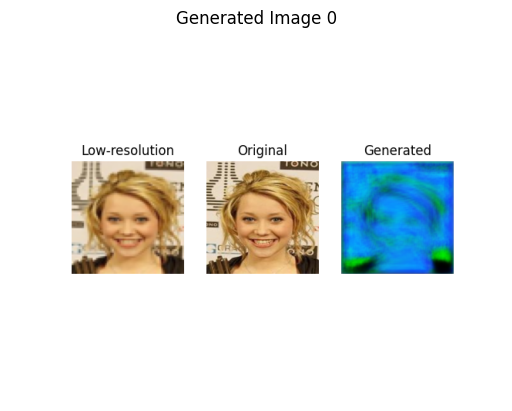

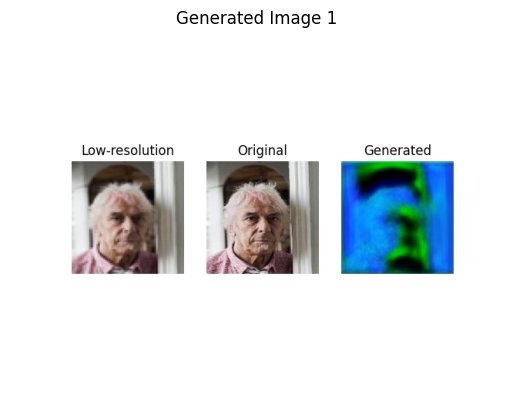

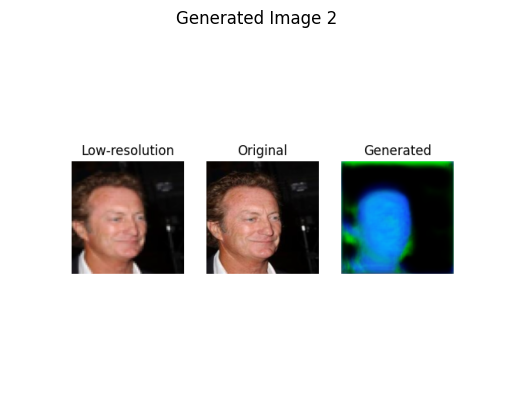

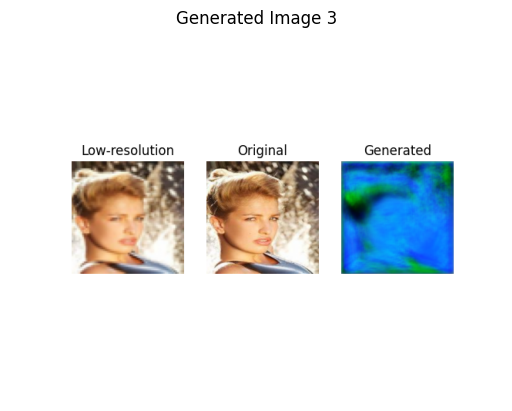

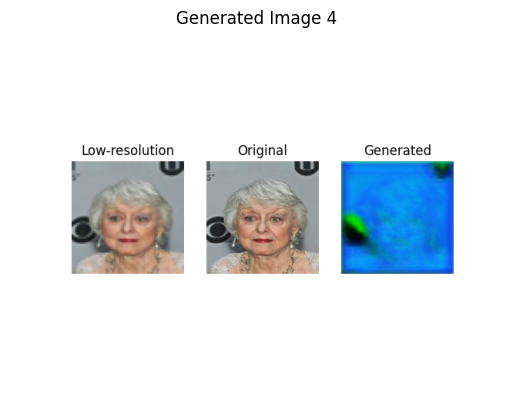

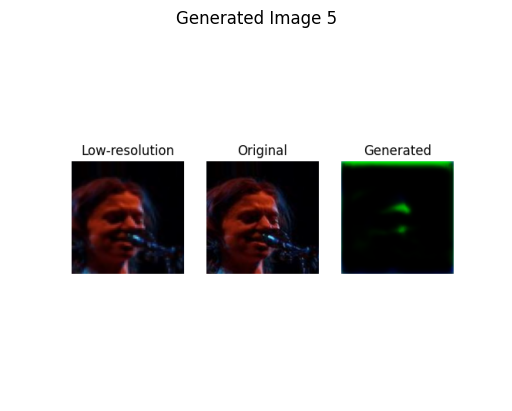

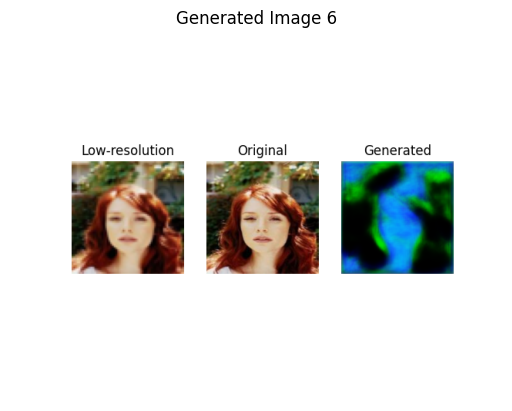

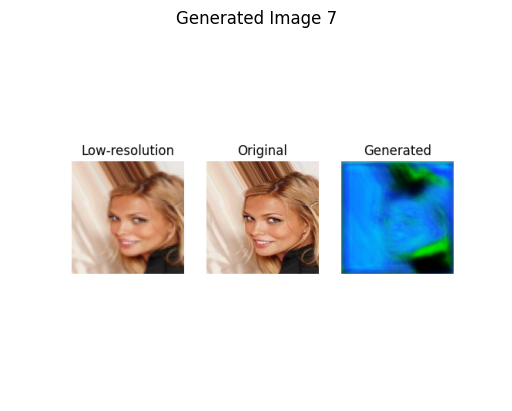

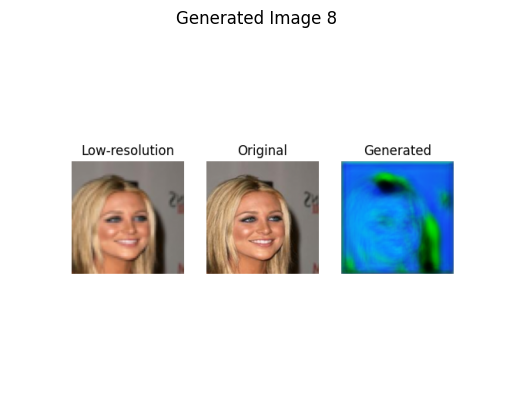

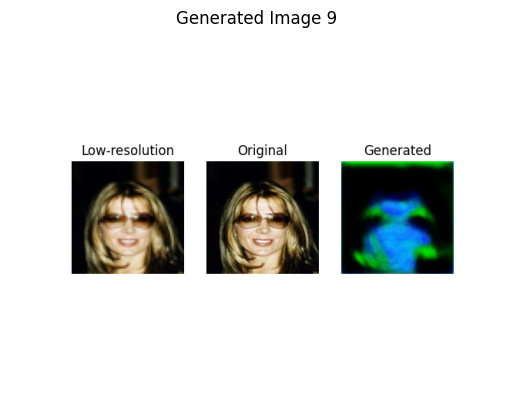

In [4]:
import glob
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, Conv2D, UpSampling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from imageio import imread
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Resize function
def imresize(arr, size):
    return np.array(Image.fromarray(arr).resize(size[:2], Image.BICUBIC))

# Load and augment images
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    all_images = glob.glob(data_dir + '/*.jpg')
    if len(all_images) == 0:
        raise ValueError(f"No images found in directory {data_dir}")

    images_batch = np.random.choice(all_images, size=batch_size)
    low_resolution_images, high_resolution_images = [], []

    for img_path in images_batch:
        img1 = np.array(Image.open(img_path).convert('RGB')).astype(np.uint8)
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    return np.array(high_resolution_images), np.array(low_resolution_images)

# Residual block for generator
def residual_block(x):
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)
    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)
    res = Add()([res, x])
    return res

# Generator model
def build_generator():
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)

    input_layer = Input(shape=input_shape)
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    res = residual_block(gen1)
    for _ in range(residual_blocks - 1):
        res = residual_block(res)
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    gen3 = Add()([gen2, gen1])
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model

# VGG model for feature extraction
def build_vgg():
    input_shape = (256, 256, 3)
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    vgg_output = vgg.get_layer("block5_conv4").output
    model = Model(inputs=vgg.input, outputs=vgg_output)
    return model

# Discriminator model
def build_discriminator():
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 3)

    input_layer = Input(shape=input_shape)
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=momentum)(dis4)
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    dis8_flattened = Flatten()(dis8)
    dis9 = Dense(units=1024)(dis8_flattened)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

# Function to save images
def save_images(low_resolution_image, original_image, generated_image, path):
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow((low_resolution_image + 1) * 0.5)
    ax.axis("off")
    ax.set_title("Low-resolution")
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow((original_image + 1) * 0.5)
    ax.axis("off")
    ax.set_title("Original")
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow((generated_image + 1) * 0.5)
    ax.axis("off")
    ax.set_title("Generated")
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path)
    plt.close()

# To write logs to Tensorboard
def write_log(callback, name, value, batch_no):
    with file_writer.as_default():
        tf.summary.scalar(name, value, step=batch_no)
        file_writer.flush()

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#data_dir = /content/drive/MyDrive/Datasets/img_align_celeba/img_align_celeba  # Replace with your dataset directory
#file_list = os.listdir(data_dir)
#print(file_list[:10])

data_dir = "/content/drive/MyDrive/Datasets/img_align_celeba/img_align_celeba"

epochs = 10
batch_size = 16
low_resolution_shape = (64, 64, 3)
high_resolution_shape = (256, 256, 3)

# Common optimizer
common_optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)

# Build and compile models
vgg = build_vgg()
vgg.trainable = False
vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=common_optimizer, metrics=['accuracy'])

generator = build_generator()

# High res. and low res. images
input_high_resolution = Input(shape=high_resolution_shape)
input_low_resolution = Input(shape=low_resolution_shape)

# Generate high-resolution images from low-resolution images
generated_high_resolution_images = generator(input_low_resolution)

# Extract feature maps of the generated images
features = vgg(generated_high_resolution_images)

# Make the discriminator network as trainable false
discriminator.trainable = False

# Get the probability of generated high-resolution images
probs = discriminator(generated_high_resolution_images)

# Create and compile an adversarial model combining
adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

# Add Tensorboard
log_dir = "/content/drive/My Drive/Datasets/logs/"
tensorboard = TensorBoard(log_dir=log_dir)
tensorboard.set_model(generator)
tensorboard.set_model(discriminator)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.00001)

# Create a file writer for TensorBoard
file_writer = tf.summary.create_file_writer(log_dir)

# Training loop
for epoch in range(epochs):
    high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                  low_resolution_shape=low_resolution_shape,
                                                                  high_resolution_shape=high_resolution_shape)
    high_resolution_images = high_resolution_images / 127.5 - 1.
    low_resolution_images = low_resolution_images / 127.5 - 1.

    generated_high_resolution_images = generator.predict_on_batch(low_resolution_images)

    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Extract features using VGG
    image_features = vgg.predict(high_resolution_images)

    # Train generator
    discriminator.trainable = False
    g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images], [real_labels, image_features])

    # Write logs to TensorBoard
    write_log(tensorboard, 'g_loss', g_loss[0], epoch)
    write_log(tensorboard, 'd_loss', d_loss[0], epoch)

    if epoch % 1 == 0:
        print(f"Epoch: {epoch} D Loss: {d_loss} G Loss: {g_loss}")
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=3,
                                                                      low_resolution_shape=low_resolution_shape,
                                                                      high_resolution_shape=high_resolution_shape)
        high_resolution_images = high_resolution_images / 127.5 - 1.
        low_resolution_images = low_resolution_images / 127.5 - 1.
        generated_images = generator.predict_on_batch(low_resolution_images)
        for index, img in enumerate(generated_images):
            save_images(low_resolution_images[index], high_resolution_images[index], img,
                        path="/content/drive/My Drive/Datasets/results/img_{}_{}.png".format(epoch, index))

# Save models
generator.save_weights("/content/drive/My Drive/Datasets/generator.h5")
discriminator.save_weights("/content/drive/My Drive/Datasets/discriminator.h5")

# Testing the Model
generator = build_generator()
generator.load_weights("/content/drive/My Drive/Datasets/generator.h5")

high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=10,
                                                              low_resolution_shape=low_resolution_shape,
                                                              high_resolution_shape=high_resolution_shape)
high_resolution_images = high_resolution_images / 127.5 - 1.
low_resolution_images = low_resolution_images / 127.5 - 1.

generated_images = generator.predict_on_batch(low_resolution_images)

for index, img in enumerate(generated_images):
    image_path = "/content/drive/My Drive/Datasets/gen_{}.png".format(index)
    save_images(low_resolution_images[index], high_resolution_images[index], img, path=image_path)

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Image {index}")
    plt.show()


In [40]:
# Save models
generator.save_weights("/content/drive/My Drive/Datasets/generator.h5")
discriminator.save_weights("/content/drive/My Drive/Datasets/discriminator.h5")

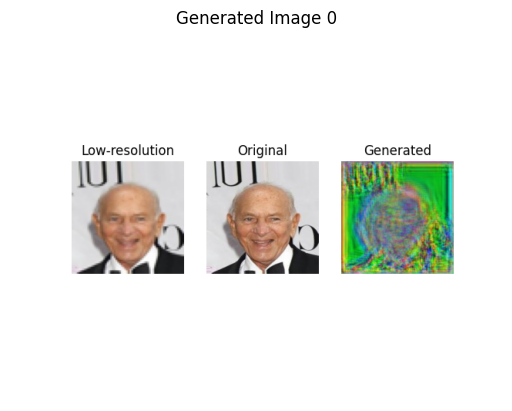

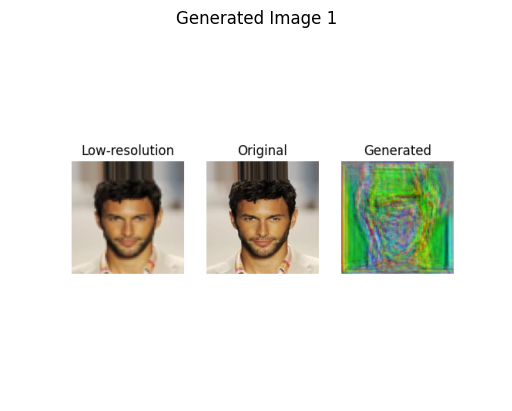

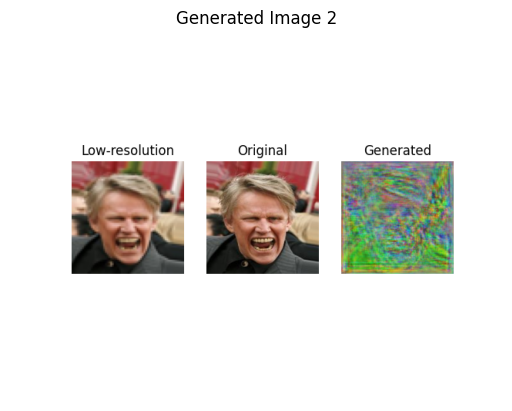

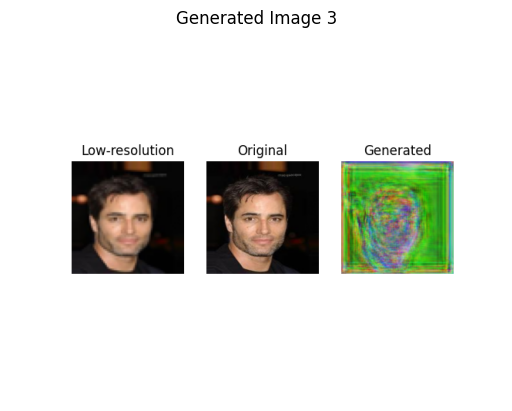

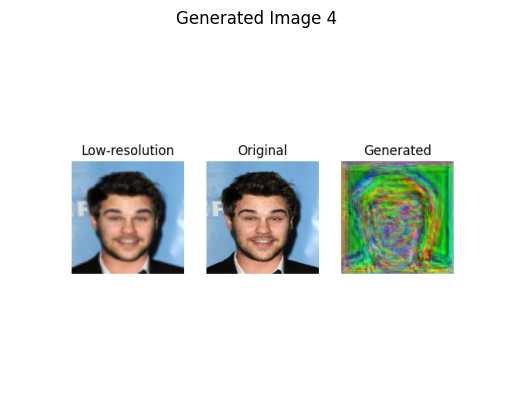

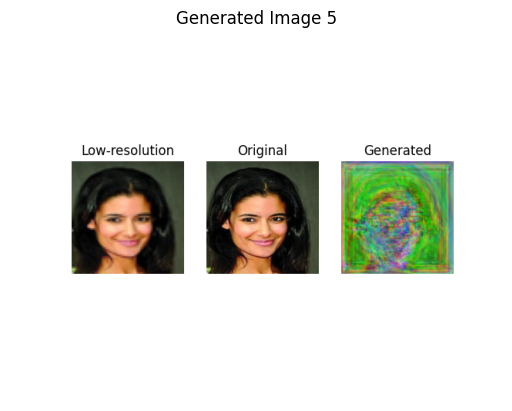

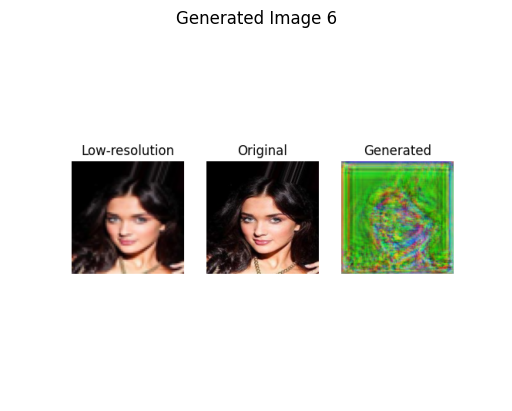

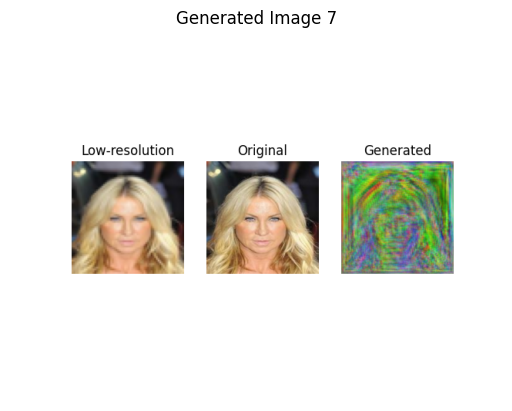

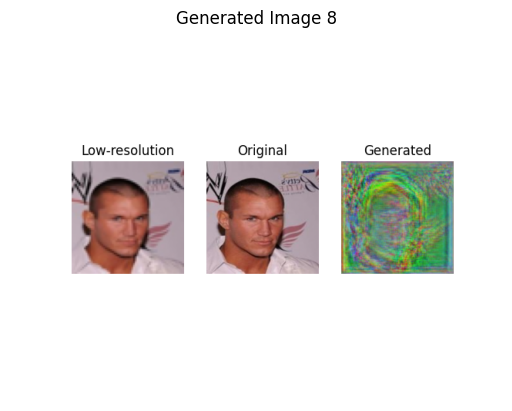

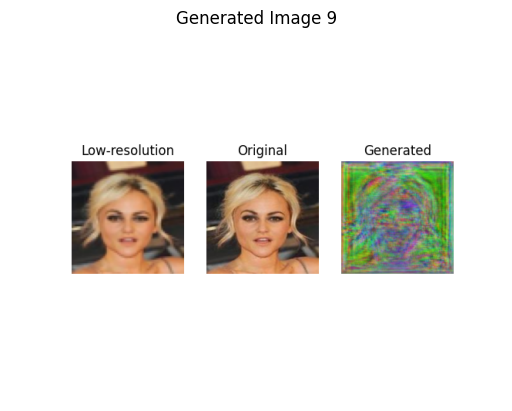

In [41]:
import matplotlib.pyplot as plt

# Testing the Model

# Build the generator network
generator = build_generator()

# Load models
generator.load_weights("/content/drive/My Drive/Datasets/generator.h5")

# Get 10 random images
high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=10,
                                                              low_resolution_shape=low_resolution_shape,
                                                              high_resolution_shape=high_resolution_shape)
# Normalize images
high_resolution_images = high_resolution_images / 127.5 - 1.
low_resolution_images = low_resolution_images / 127.5 - 1.

generated_images = generator.predict_on_batch(low_resolution_images)

# Save and display images
for index, img in enumerate(generated_images):
    image_path = "/content/drive/My Drive/Datasets/gen_{}.png".format(index)
    save_images(low_resolution_images[index], high_resolution_images[index], img, path=image_path)

    # Display the saved image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.title(f"Generated Image {index}")
    plt.show()